In [1]:
import numpy as np
import healpy as hp
%matplotlib inline
import matplotlib.pylab as plt
from desi_north import DesiFootprint, make_rolling_footprints


from rubin_sim.scheduler.model_observatory import ModelObservatory
from rubin_sim.scheduler.schedulers import CoreScheduler, FilterSchedUzy
from rubin_sim.scheduler.utils import (
    EuclidOverlapFootprint,
    ConstantFootprint, Footprints, slice_quad_galactic_cut,
    Footprint, StepSlopes, BasePixelEvolution
)
import rubin_sim.scheduler.basis_functions as bf
from rubin_sim.scheduler.surveys import (
    GreedySurvey,
    BlobSurvey,
    ScriptedSurvey,
    LongGapSurvey,
    generate_ddf_scheduled_obs, 
)
from rubin_sim.scheduler import sim_runner
import rubin_sim.scheduler.detailers as detailers
import sys
import subprocess
import os
import argparse
from astropy.coordinates import SkyCoord
from astropy import units as u
from rubin_sim.utils import _hpid2_ra_dec
import rubin_sim

In [2]:
fpg = DesiFootprint()
maps, labels = fpg.return_maps()

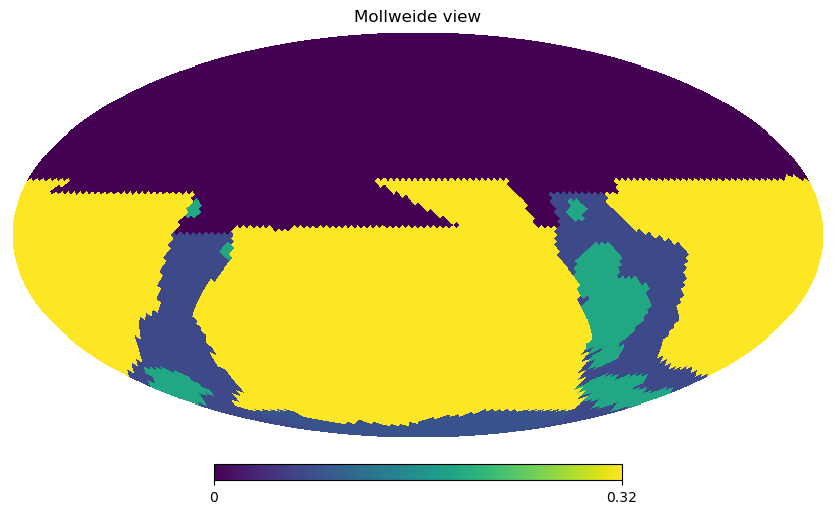

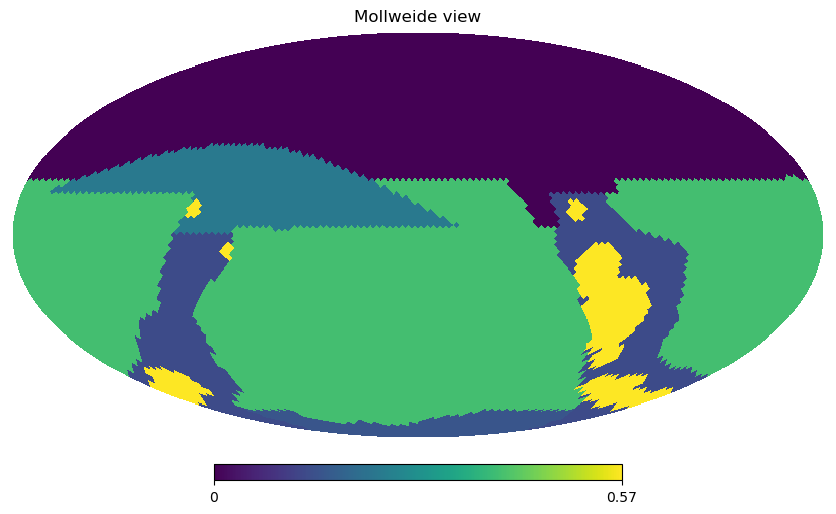

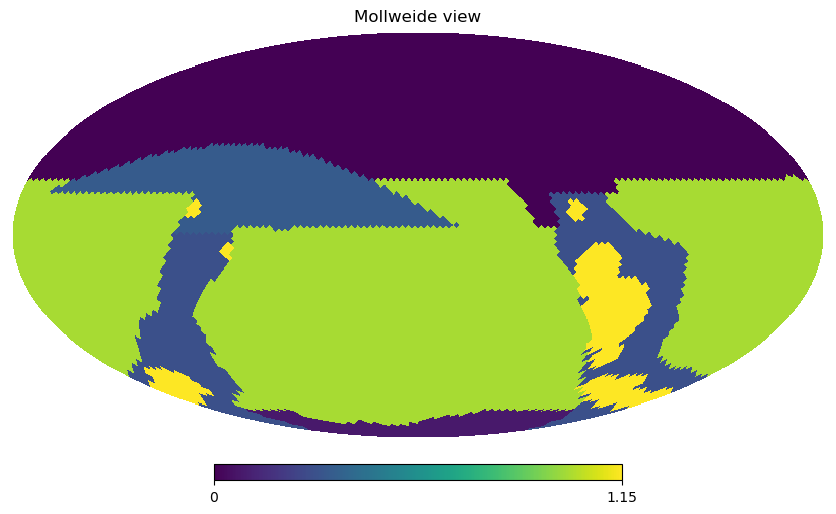

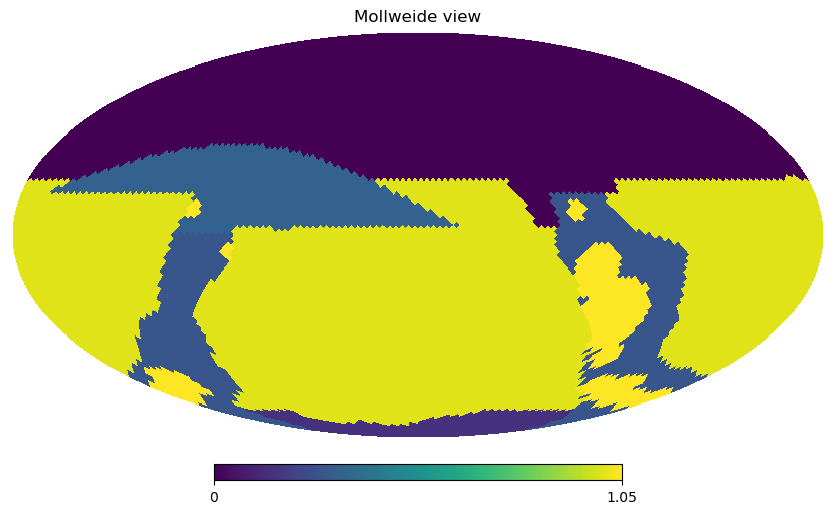

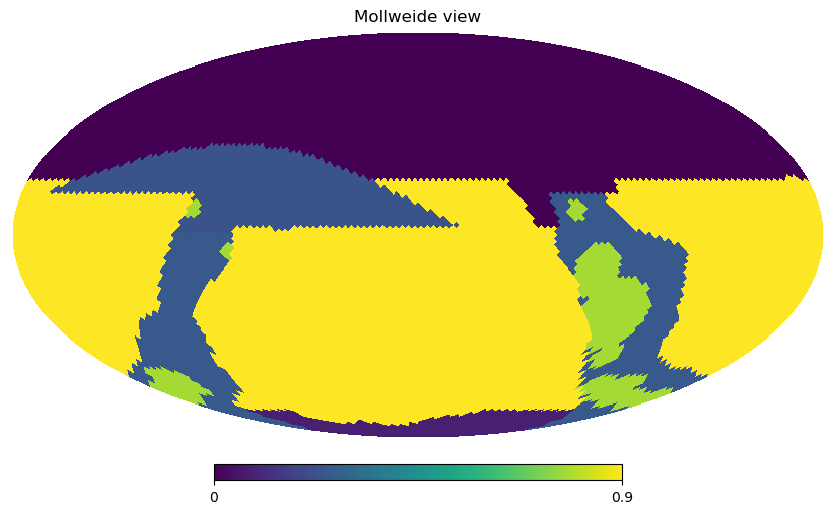

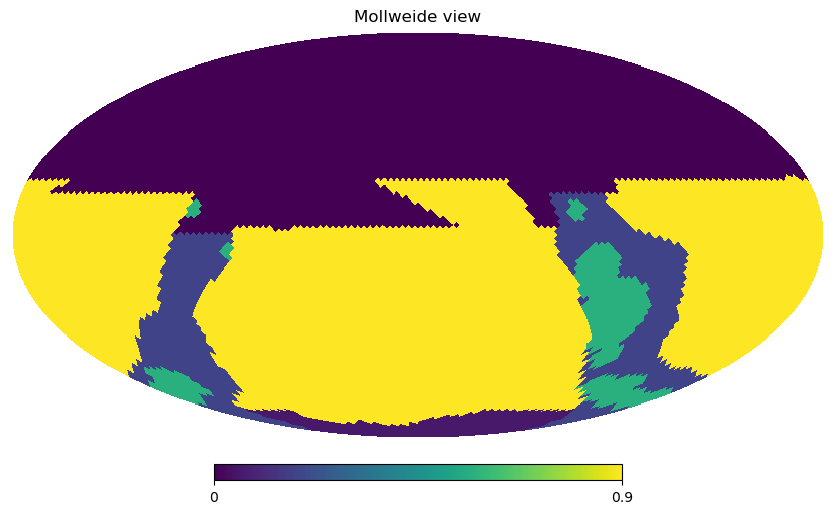

In [3]:
for key in maps.dtype.names:
    hp.mollview(maps[key])

In [4]:
maps

array([(0.  , 0.  , 0.  , 0.  , 0.  , 0.  ),
       (0.  , 0.  , 0.  , 0.  , 0.  , 0.  ),
       (0.  , 0.  , 0.  , 0.  , 0.  , 0.  ), ...,
       (0.08, 0.15, 0.08, 0.15, 0.08, 0.06),
       (0.08, 0.15, 0.08, 0.15, 0.08, 0.06),
       (0.08, 0.15, 0.08, 0.15, 0.08, 0.06)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

In [5]:
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'desi north', 'dusty_plane',
       'euclid_overlap', 'lowdust', 'nes', 'scp', 'virgo'], dtype='<U20')

In [6]:
 # Modify the footprint
nside=32
mjd_start = 60676.0
nslice = 2
rolling_scale = 0.9
sky = EuclidOverlapFootprint(nside=nside, smc_radius=4, lmc_radius=6)
footprints_hp_array, labels = sky.return_maps()

wfd_indx = np.where(
    (labels == "lowdust") | (labels == "LMC_SMC") | (labels == "virgo")
)[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprint_mask = footprints_hp["r"] * 0
footprint_mask[np.where(footprints_hp["r"] > 0)] = 1

repeat_night_weight = None

observatory = ModelObservatory(nside=nside, mjd_start=mjd_start)
conditions = observatory.return_conditions()

# set up the desi footprint
all_fp = DesiFootprint()
desi_hp, desi_label = all_fp.return_maps()

fp_north_hp = {}
for key in desi_hp.dtype.names:
    temp = desi_hp[key]*0
    indx = np.where(desi_label == 'desi north')[0]
    temp[indx] = desi_hp[key][indx]
    fp_north_hp[key] = temp

footprints = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=conditions.mjd_start,
    sun_ra_start=conditions.sun_ra_start,
    nslice=nslice,
    scale=rolling_scale,
    nside=nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=4,
    fp_north_hp=fp_north_hp
)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/sky_model_pre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


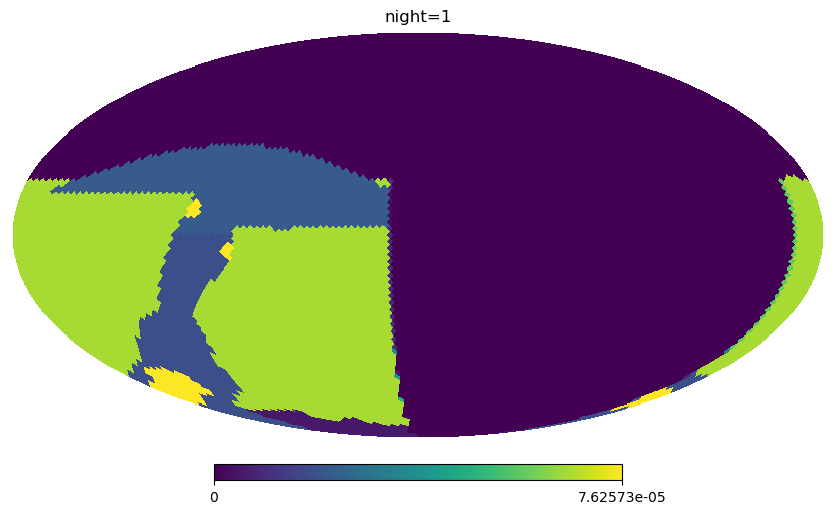

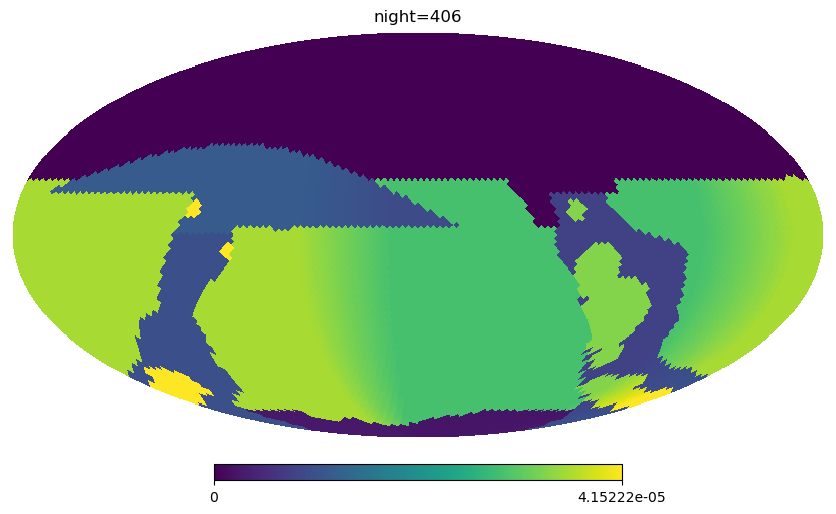

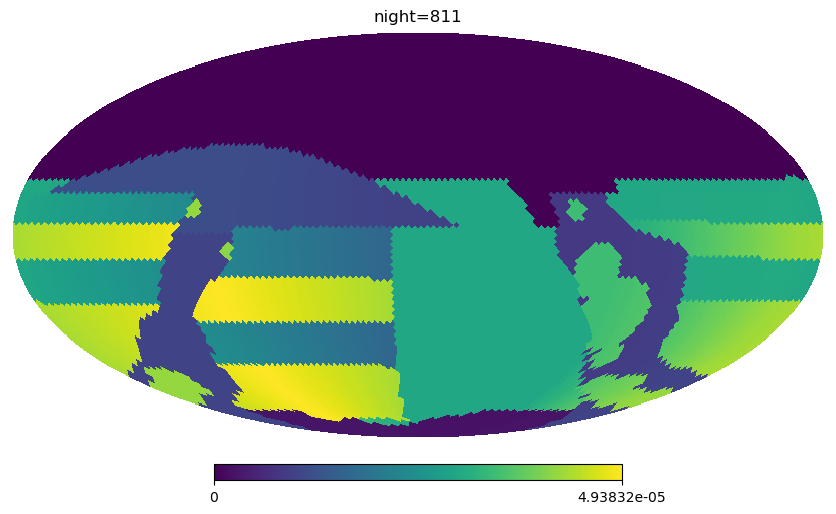

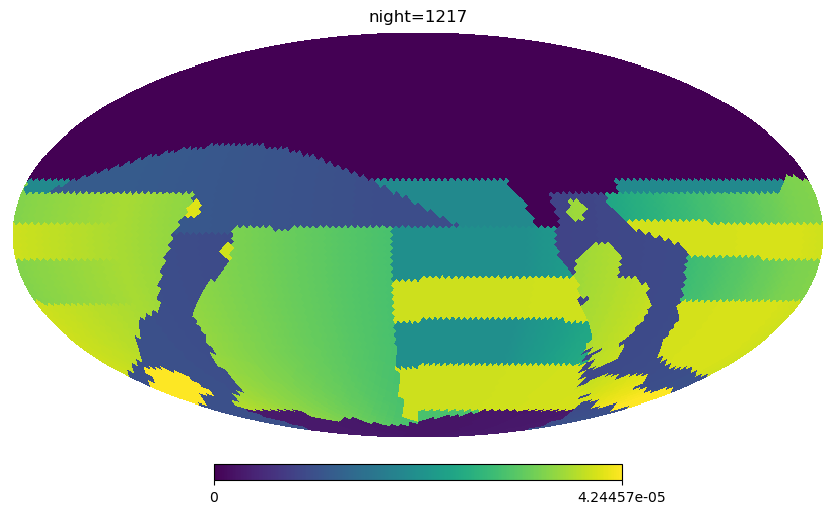

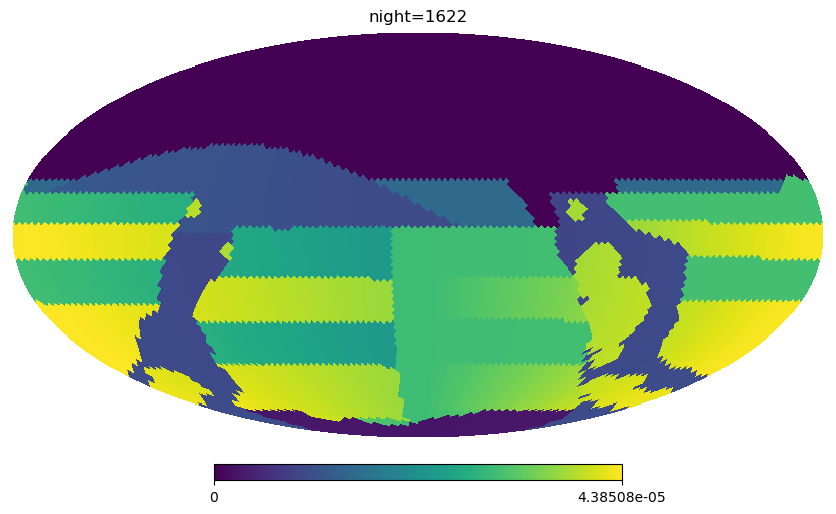

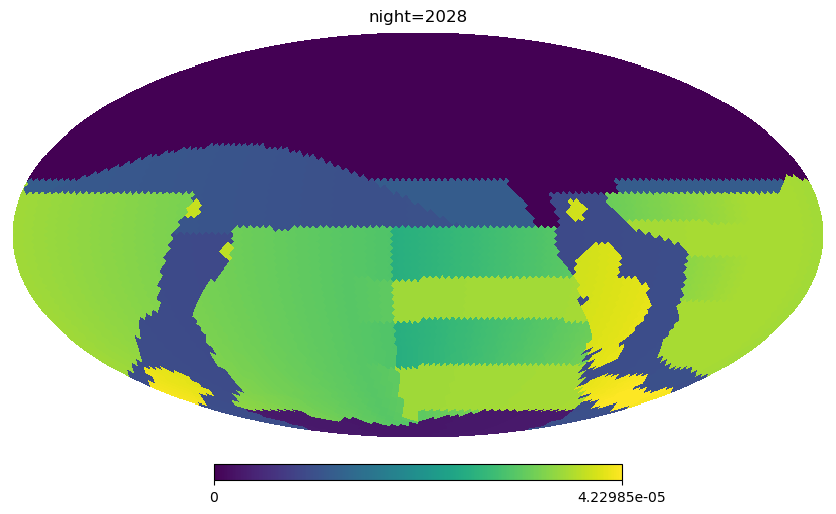

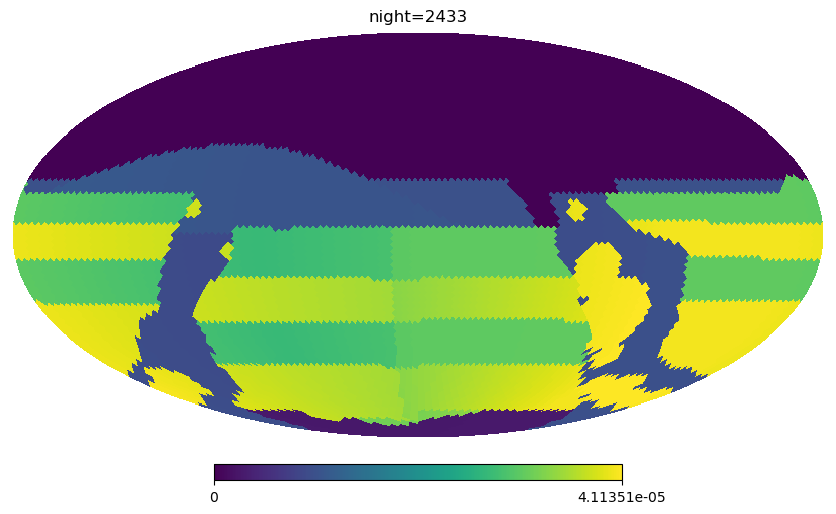

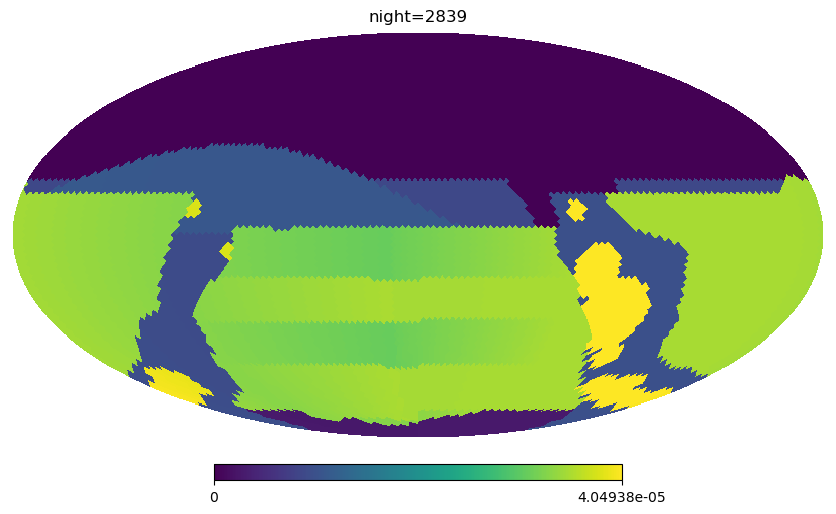

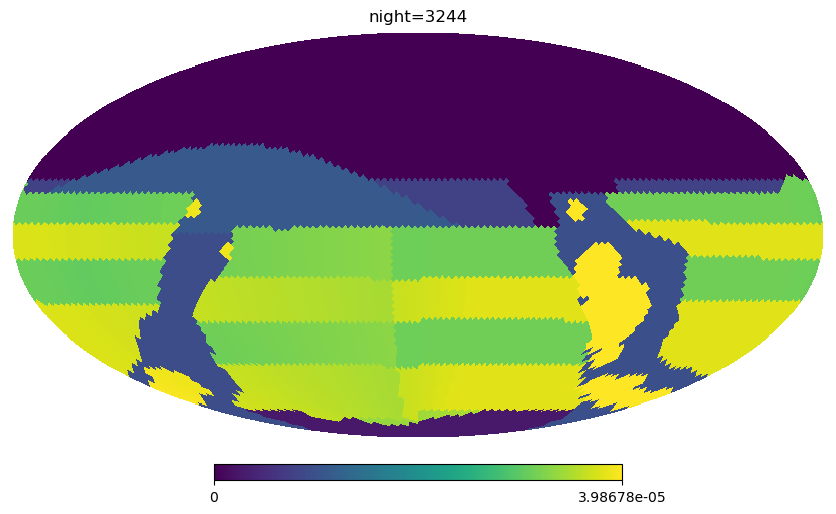

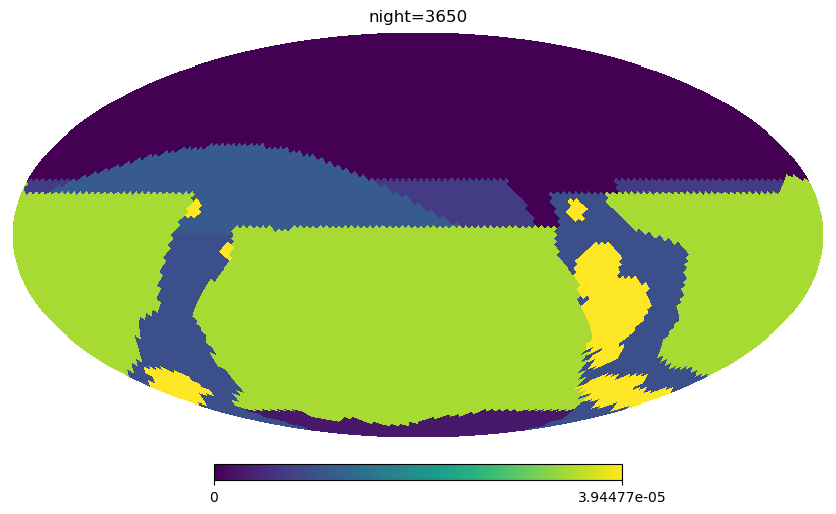

In [7]:
mjds = np.linspace(1,365*10, 10) + conditions.mjd_start

for mjd in mjds:
    fp_at_mjd = footprints(mjd)
    hp.mollview(fp_at_mjd['r'], title='night=%i' % (mjd-conditions.mjd_start))
